In [1]:
from functools import wraps
import json
import os
import time

import datarobot as dr
from datarobot_bp_workshop import Visualize
import datarobotx as drx
from logzero import logger
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd
import requests
from sklearn.metrics import log_loss
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

2023-09-21 20:36:16.778067: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Semi Supervised Learning with Hugging Face LLMs and DataRobot


## TL/DR
In this post, I show a few approaches for handling text classification problems both with and without training labels. 

## Goal

In all of the buzz with generative AI or 'foundation models', many people take at face value that LLMs like GPT, Roberta and others can be used to superior effect on virtually any task, especially in one involving text or image data. 

My goal in this notebook is to make a rough empirical test for this claim. I will then provide methods for using LLMs in tandem with traditional Machine Learning models in order to appropriately solve a problem. The scenario will be as follows:

I am a bank (Without any more detail, are you already bored by this scenario? I don't care. I worked at a bank. Bear with me. My blog, my way.) I have a bunch of emails I want to classify to be in one of four channels so that I can route it somewhere. Ideally, a machine would do this for me because:

1. Routing emails is boring.
2. These emails are all customer complaints so it's depressing in addition to boring.
3. I don't know anything about the domain and don't know how to decide where to send any of these.
4. Some of these emails are in Spanish, which I don't speak fluently. Some are in French which I don't speak at all.

How might we approach this problem? I'll highlight four ways here and highlight code for each one.
- Traditional Supervised Learning
- Zero Shot Inference
- Fine Tuning (Supervised Learning for LLMs)
- A combination of Zeroshot Learning and Supervised Learning

Of course for any of these problems, we need some kind of data to make predictions on. And so I pull up an email triage dataset below. 

## Our Dataset

In [2]:
df = pd.read_csv('https://s3.amazonaws.com/datarobot_public/drx/email_training_dataset.csv').drop(columns='Unnamed: 0')
target = 'Transaction_Type'
primary_feature = 'Consumer_complaint_summary'
print(df.shape)
df.head()

(12290, 8)


,Date_received,Transaction_Type,Company_response,Date_sent_to_company,Consumer_disputes,Consumer_complaint_summary,summary_length,summary_words
0,5/7/2015,Bank account or service,NaN,5/7/2015,No,"El XXXX / XXXX / 15, estaba preparando el vuel...",3853,720
1,9/29/2016,Credit card,Company has responded to the consumer and the ...,9/29/2016,No,J'ai obtenu un compte de crédit de soins pour ...,1013,185
2,10/15/2016,Bank account or service,Company has responded to the consumer and the ...,10/15/2016,No,"Je suis en train de faire faillite et, par con...",1018,172
3,3/5/2016,Credit card,NaN,3/5/2016,No,My boyfriend and I bought a XXXX sofa and we h...,1147,215
4,12/28/2016,Consumer Loan,NaN,12/28/2016,No,In XX / XX / XXXX we open a lease with XXXX DB...,1573,303


In this dataset the goal is to predict the "Transaction_Type" that a customer is sending a complaint about. There are four transaction types an email can reference: Consumer Loan, Student Loan, Bank Account or Service, and Credit Card.

<Axes: title={'center': 'Distribution of our Classes of Emails\n (we want to predict this)'}>

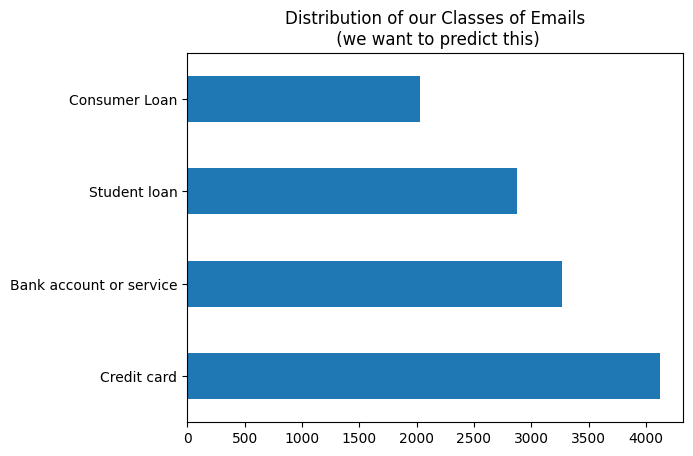

In [3]:
# Show class distribution
(df[target]
 .value_counts()
 .plot(kind='barh', title='Distribution of our Classes of Emails\n (we want to predict this)')
)


There are multiple fields in this dataset that could be correlated with the transaction type but the primary field that will tell us is simply the body of the email, which is listed in `Consumer_complaint_summary`. Below I show an email about canceling a credit card from Bank of America. Apparently, Bank of America did not make this an easy process for their customers when this dataset was created. The transaction type is marked as 'Credit Card', which makes sense given the content of the email. 

In [5]:
print(f"Complaint Summary:\n\n{df.Consumer_complaint_summary[10]}\n{'-'*100}\nTransaction_Type: {df.Transaction_Type[10]}")

Complaint Summary:

I have been trying to cancel a Bank of America XXXX credit card and request reimbursement of the annual fee. When I first called, the Bank of America associate assured me that my card would be canceled and that the annual fee charged recently will be refunded.

The card seems to be canceled, however, the balance of the annual fee still appears on my statement.

I already tried to call twice, and both times the wait time exceeded 40 minutes. I tried to send the request online, but I received a message that these types of requests must be answered by phone. I'm calling again today, still waiting.
----------------------------------------------------------------------------------------------------
Transaction_Type: Credit card


I mentioned above that other fields might be correlated with the transaction type in some way. In this project, I only use the `Consumer_complaint_summary` as a feature. I need to do this because LLMs don't have a way to use other features to generate their inference unless the user does some very clever preprocessing to stuff all of the relevant information into one big text feature. Score one for our first approach, supervised machine learning that don't involve LLMs!

In [6]:
df = df[[target, primary_feature]]
df.head()

,Transaction_Type,Consumer_complaint_summary
0,Bank account or service,"El XXXX / XXXX / 15, estaba preparando el vuel..."
1,Credit card,J'ai obtenu un compte de crédit de soins pour ...
2,Bank account or service,"Je suis en train de faire faillite et, par con..."
3,Credit card,My boyfriend and I bought a XXXX sofa and we h...
4,Consumer Loan,In XX / XX / XXXX we open a lease with XXXX DB...


### Approach 1: Supervised Machine Learning

Given we have a training dataset, the actual Machine Learning process in this approach is easy or at least routine. We just need to do some NLP to featurize our text data and fit a model. If we do a good job with all of the standard ML workflow stuff (properly partitioning, feature engineering, hyper parameter tuning, model selection etc..) we end up with a model that generalizes well to unseen data. Yay! Some tools can do part or even all of the work in this process. Yay! DataRobot is one of them and I work there. 

What? You want open source **and** you want to follow along? Tough luck, friend. I'm here to solve a problem, not implement a pipeline many people have already implemented. So, DataRobot. Or whatever you want I guess. I'm not going to hunt you down if you don't follow along or if you decide to use scikit-learn, keras, or even a competitor like h20 or (*barf*) Dataiku.

In [7]:
# Hold out some data to evaluate later
X_train, X_test = df[:10000], df[10000:].reset_index(drop=True)
print(X_train.shape, X_test.shape)

(10000, 2) (2290, 2)


In [8]:
# Shove some data into DataRobot
email_classifier_model = drx.AutoMLModel(name="Email Classifier").fit(X_train, target=target)

VBox()

Small aside here, but yes, the one liner above is genuinely all you need to do to perform machine learning on a multiclass and mulitlingual text problem. I'm not sure if this is a testament to DataRobot specifically or the progression of the field in general. Probably more the latter but I do take some pride in my company's software. 

In [11]:
email_classifier_model._best_model

VBox()

VBox()

In the project, I see that most models tried after preprocessing were [Stochastic Gradient Descent Classifiers](http://scikit-learn.org/stable/modules/sgd.html#sgd). Given I gave the project just one feature to use, I can't imagine the preprocessing done for any of these was incredibly complicated. I confirm that our best model just ran [tfidf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) on the ngrams value of our text columns before fitting into our model. 

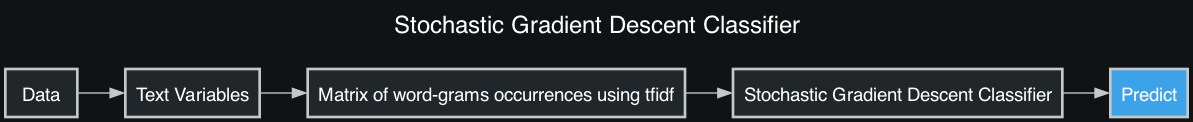

In [403]:
project_id = email_classifier_model._project_id
project = dr.Project.get(project_id)
top_model = project.get_top_model()
bp_chart = dr.Blueprint.get(project_id, top_model.blueprint_id)

Visualize.show_dr_blueprint(bp_chart)

### Evaluate

Our leaderboard suggests this model is pretty accurate. It's AUC is 0.97 and its [balanced accuracy](https://docs.datarobot.com/en/docs/modeling/reference/model-detail/opt-metric.html#accuracybalanced-accuracy) is 86%. But who trusts enterprise software these days? Lets see how it predicts on my held out dataset.

In [404]:
pred_probas = email_classifier_model.predict_proba(X_test)
preds = email_classifier_model.predict(X_test)

VBox()

VBox()

In [407]:
X_eval = pd.concat((X_test.reset_index(drop=True), preds, pred_probas),axis=1)
X_eval.head()

,Transaction_Type,Consumer_complaint_summary,prediction,class_Bank account or service,class_Consumer Loan,class_Credit card,class_Student loan
0,Credit card,I have had this Bank of America credit card si...,Credit card,0.015389,0.000723,0.972247,0.011640
1,Consumer Loan,mi pago fue devuelto por la razón dada ... pag...,Consumer Loan,0.186634,0.301319,0.254186,0.257861
2,Bank account or service,I was trying to use my debit card XXXX / XXXX ...,Bank account or service,0.997043,0.001156,0.001622,0.000178
3,Bank account or service,"Mes deux parents sont décédés, me laissant com...",Bank account or service,0.865719,0.041147,0.044492,0.048642
4,Consumer Loan,The ACE CASH services have threatened to take ...,Consumer Loan,0.004686,0.737329,0.021331,0.236654


In [406]:
accuracy = (X_eval[target]==X_eval['prediction']).sum() / len(X_test)
prediction_probabilities = pred_probas.values
logloss = log_loss(X_eval[target], prediction_probabilities, labels=[i.replace('class_', "") for i in pred_probas.columns.to_list()])

print("Accuracy {:.2%}".format(accuracy))
print("LogLoss {:.2}".format(logloss))

Accuracy 87.60%
LogLoss 0.35


Yup pretty much aligns with what the leaderboard reported, which shouldn't be suprising but it's always nice to verify.

### Perks and drawbacks of this approach

On problems involving natural language processing and really, any problems containing features with signal, the "traditional ML" approach is nice here for a couple of reasons.

Stengths:
- Training is reasonably fast
- Inference time is fast
- Accuracy is good
- It can use features that aren't text to predict an outcome (although we didn't for the sake of comparison)

Weaknesses:
- You need a training dataset
- A fancy implementation of a logistic regression is not as fancy as a 'Deep Neural Network'

## Approach 2: Zeroshot Inference with LLMs

While traditional machine learning works for this problem and most other problems where the goal is to compute a continuous or categorical outcome, it assumes the user comes ready with a **labeled** training dataset. In practice this is not always true. Part of my job is helping our sales people sell our product. I do this by showing customers cool things they can build with machine learning. Customers often respond with enthusiasm when they think of all of the problems they can solve at their company with machine learning. Yet many a sale has died when the prospect discovers in practice that they don't have any labeled training data.

### Concept

One idea many people have for LLMs is to apply them on datasets with this exact problem. Generally, the method for handling this problem goes something like this:
1. Come up with potential labels for your dataset. In our case, that's still one of Consumer Loan, Student Loan, Bank Account or Service, and Credit Card.
2. Feed each label into an LLM and extract its [embedding](https://huggingface.co/blog/getting-started-with-embeddings), which is a fancy phrase for a vector of numbers representing an LLMs numeric representation of the label.
3. Repeat for all records:
    - Feed text feature into LLM and extract its embedding
    - Set record label as $ c = \underset{c}{\mathrm{argmax}} \space​ cos(Φ(x),Φ(c))$ where $Φ(x)$ represents the the encoding from the text and $Φ(c)$ represents the encoding from the labels.
        - [Cosine similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) is a common distance measure used to do this

And then you're done! In theory, no hand labeled data needed. I diagram this process below.
![How zero-shot classification works](images/zero-shot-diagram.jpg)

### Implementation

So let's see if it works. I'll use the `transformers` library from Huggingface to run zero shot learning on the dataset. Of course, Huggingface actually has 119 models hosted for the exact purpose of zero-shot learning and we would ideally find a way to intelligently choose which model to use for this problem. Besides taking a very long time to compute predictions on a bunch of LLMs, performing model selection also requires some form of validation data, which we're not supposed to have in this scenario. In this case I opted to use [bart-large-mnli](https://huggingface.co/facebook/bart-large-mnli). I chose this model because it had the most downloads and upvotes of any model at the time of writing. 

In [49]:
model = "facebook/bart-large-mnli"
input_dir = 'local-checkpoint'

tokenizer = AutoTokenizer.from_pretrained(model)
nli_model = AutoModelForSequenceClassification.from_pretrained(model)

In [50]:
text_classifier = pipeline("zero-shot-classification", model=nli_model, tokenizer=tokenizer)
# Save if you don't want to download again
nli_model.save_pretrained(input_dir)
tokenizer.save_pretrained(input_dir)

('local-checkpoint/tokenizer_config.json',
 'local-checkpoint/special_tokens_map.json',
 'local-checkpoint/vocab.json',
 'local-checkpoint/merges.txt',
 'local-checkpoint/added_tokens.json',
 'local-checkpoint/tokenizer.json')

### Make inferences

Unfortunately, it takes it about 8 seconds to score each record using this model on my MacBook Pro CPU, so I had to downsample my evaluation set. Not to give undo props to DataRobot, but if we're scoring Zero-Shot Inference against AutoML, it turns out it is far faster for an end user to train, evaluate then get predictions from about 20 models for this problem than it is to make predictions from this single LLM.

In [275]:
np.random.seed(42)
# X_test_down_sample = df
candidate_labels = df['Transaction_Type'].unique().tolist()
consumer_complaints = df['Consumer_complaint_summary'].tolist()

def run_zeroshot_inference(classifier, text, candidate_labels, log_every=100, clear_output=False):
    "Make zero shot predicitons"
    
    def divide_chunks(l, n=100):
        for i in range(0, len(l), n):
            yield l[i:i + n]
    def write_output(predictions, path, overwrite=False):
        with open(path, 'r') as f:
            data = json.load(f)
        if overwrite:
            data['data'] = predictions
        else:
            data['data'] += predictions
        with open(path, 'w') as f:
            json.dump(data, f)
            
    outpath = "data/zero_shot_predictions.json"
    if clear_output:
        write_output([], outpath, clear_output)
    else:
        with open(outpath, 'r') as f:
            d = json.load(f)
            text = text[len(d['data']):]
        
    text_chunks = list(divide_chunks(text, n=log_every))
    for i, group in enumerate(text_chunks):
        logger.info(f"Running Zero Shot Inference on group {i+1}")
        group_predictions = [classifier(record, candidate_labels) for record in group]
        inference_out = [{'labels': i['labels'], 'scores': i['scores']} for i in group_predictions]
        write_output(inference_out, outpath)
    return outpath

run_zeroshot_inference(text_classifier, consumer_complaints, candidate_labels, log_every=500, clear_output=False)

[I 230508 09:41:12 694847491:31] Running Zero Shot Inference on group 1
[I 230508 11:17:33 694847491:31] Running Zero Shot Inference on group 2
[I 230508 12:42:10 694847491:31] Running Zero Shot Inference on group 3
[I 230508 13:55:34 694847491:31] Running Zero Shot Inference on group 4
[I 230508 15:35:36 694847491:31] Running Zero Shot Inference on group 5
[I 230508 16:53:32 694847491:31] Running Zero Shot Inference on group 6
[I 230508 18:22:16 694847491:31] Running Zero Shot Inference on group 7
[I 230508 19:25:03 694847491:31] Running Zero Shot Inference on group 8
[I 230509 07:34:33 694847491:31] Running Zero Shot Inference on group 9
[I 230509 08:43:34 694847491:31] Running Zero Shot Inference on group 10
[I 230509 11:02:46 694847491:31] Running Zero Shot Inference on group 11
[I 230509 12:26:30 694847491:31] Running Zero Shot Inference on group 12
[I 230509 15:08:42 694847491:31] Running Zero Shot Inference on group 13
[I 230509 16:22:19 694847491:31] Running Zero Shot Inference

In [390]:
# json_preds

In [396]:
with open('data/zero_shot_predictions.json', 'r') as f:
    json_preds = json.load(f)['data']
    zero_shot_predictions = pd.DataFrame(dict(prediction = [i['labels'][0] for i in json_preds], scaled_similarity = [i['scores'][0] for i in json_preds]))
    for transaction_type in ['Consumer Loan', 'Bank account or service', 'Credit card', 'Student loan']:
        zero_shot_predictions[transaction_type] = [i['scores'][i['labels'].index(transaction_type)] for i in json_preds]

zero_shot_predictions

,prediction,scaled_similarity,Consumer Loan,Bank account or service,Credit card,Student loan
0,Bank account or service,0.331196,0.290377,0.331196,0.244425,0.134003
1,Bank account or service,0.391387,0.193196,0.391387,0.334984,0.080433
2,Bank account or service,0.464648,0.099698,0.464648,0.375043,0.060611
3,Bank account or service,0.609222,0.105634,0.609222,0.264156,0.020988
4,Bank account or service,0.433630,0.202371,0.433630,0.298585,0.065413
...,...,...,...,...,...,...
12285,Consumer Loan,0.797441,0.797441,0.091895,0.096323,0.014340
12286,Bank account or service,0.565619,0.027464,0.565619,0.396140,0.010777
12287,Bank account or service,0.804746,0.063040,0.804746,0.097282,0.034933
12288,Credit card,0.861674,0.045540,0.083127,0.861674,0.009659


### Evaluate

Now I can take our last 2290 predictions and compare them to the held out dataset to figure out a measure of accuracy. 

<Axes: title={'center': 'Distribution of Actual Labels'}>

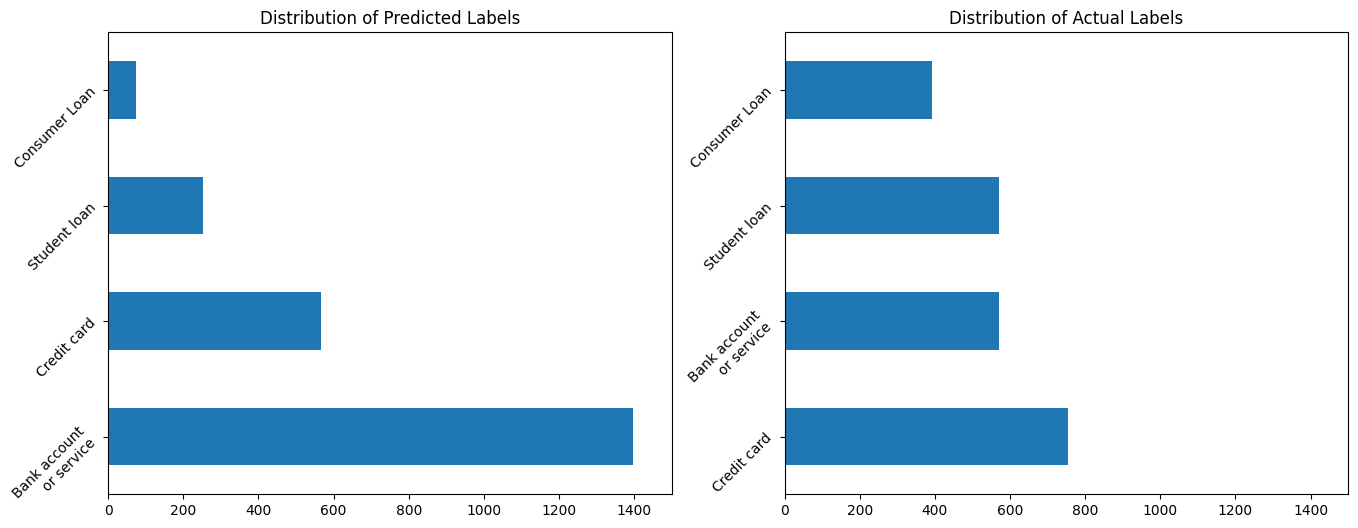

In [393]:
zero_shot_evaluate_predictions = zero_shot_predictions[10000:].reset_index(drop=True)

fig, ax = plt.subplots(1,2, figsize=(16,6))
(zero_shot_evaluate_predictions
 .assign(prediction = lambda x: np.where(x.prediction == 'Bank account or service', 'Bank account\nor service', x.prediction))['prediction']
 .value_counts()
 .plot(kind='barh', title='Distribution of Predicted Labels', ax=ax[0], xlim=[0, 1500], rot=45)
)
(X_test
 .assign(Transaction_Type = lambda x: np.where(x.Transaction_Type == 'Bank account or service', 'Bank account\nor service', x.Transaction_Type))['Transaction_Type']
 .value_counts()
 .plot(kind='barh', title='Distribution of Actual Labels', ax=ax[1], xlim=[0, 1500], rot=45)
)

Already we can see the distribution of the labels is different from the original training dataset. The phrase 'Bank account or service' seems to dominate the results. It's possible that the embedding for 'Bank Account or Service' matches is getting higher match scores because the name is longer. An important issue to note with zero shot inference is that the labels you choose, whether for NLP problems or visual classification problems, matter a lot. Below, I also show that the model is not very accurate. Using this, there is a little better than a coin flip's chance of being right. Still, being right over half the time is better than being right a quarter of the time, which is where we would stand with a random guess.

In [423]:
accuracy = (zero_shot_evaluate_predictions['prediction']==X_test[target]).sum() / len(X_test)
prediction_probabilities = zero_shot_evaluate_predictions.scaled_similarity
logloss = log_loss(X_test[target], zero_shot_evaluate_predictions.iloc[:,-4:], labels=zero_shot_evaluate_predictions.iloc[:, -4:].columns.to_list())

print("Accuracy {:.2%}".format(accuracy))
print("LogLoss {:.2}".format(logloss))

Accuracy 55.07%
LogLoss 1.5


### Perks and drawbacks of this approach

Stengths:
- You don't need to hand label anything!
- There is no overhead for training. Just ping something that exists and get a result
- You get to use LLMs
- Zero-shot inference sounds cool

Weaknesses:
- Inference takes a very long time
- The model was not as accurate as other methods
- Writing poor candidate labels can destroy your predictions
- You can only use one feature which must be freeform text or an image
- Your stuck with classification problems. Continuous outcomes cannot be predicted with this method

## Approach 3: Finetuning with fancier LLMs

The prohibitively long inference time and lack of accuracy in a fairly run of the mill text classification problem likely disqualify zero-shot inference as a substitute for most practical NLP problems. But to be fair on the accuracy side, we took an LLM specialized for one task and forced it to do another without any form of training. If we're willing to acknowledge the need for training data, we could instead opt to [Fine Tune](https://platform.openai.com/docs/guides/fine-tuning) our LLMs for the task at hand.

From the Open AI Docs:

*"Fine-tuning lets you get more out of the models available through the API by providing:*

1. *Higher quality results than prompt design*
2. *Ability to train on more examples than can fit in a prompt*
3. *Token savings due to shorter prompts*
4. *Lower latency requests*

*GPT-3 has been pre-trained on a vast amount of text from the open internet. When given a prompt with just a few examples, it can often intuit what task you are trying to perform and generate a plausible completion. This is often called "few-shot learning."*

*Fine-tuning improves on few-shot learning by training on many more examples than can fit in the prompt, letting you achieve better results on a wide number of tasks. Once a model has been fine-tuned, you won't need to provide examples in the prompt anymore. This saves costs and enables lower-latency requests."*

Sounds great to me, specifically for the high quality responses and low latency requests. For most of this, I followed along the guide in the [OpenAI cookbook](https://github.com/openai/openai-cookbook/blob/main/examples/Fine-tuned_classification.ipynb).

Even more helpfully, OpenAI has a data preparation CLI. Neat! 

In [132]:
candidate_labels

['Bank account or service', 'Credit card', 'Consumer Loan', 'Student loan']

In [63]:
X_finetune = X_train.rename(columns={'Transaction_Type':'completion', 'Consumer_complaint_summary': 'prompt'})


X_finetune.to_json("data/x_train-finetune.jsonl", orient='records', lines=True)


In [68]:
!openai tooles fine_tunes.prepare_data -f data/x_train-finetune.jsonl -q

Analyzing...

- Your file contains 10000 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 5 duplicated prompt-completion sets. These are rows: [2938, 6612, 8243, 9079, 9445]
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty
- The completion should start with a whitespace character (` `). This tends to produce better results due to the tokeni

Wow, Besides all of the setting with copy warnings this came out with, I'm pretty impressed with this prompting. It did all of the data prep for fine tuning for me. It even found a few duplicate records I didn't know about, recommended a model to save me time and money, gave me an estimate about the length of time my fine tuning process would take, and even told me exactly what I needed to type in order to actually do the fine tuning. Hurray! 


In [69]:
!openai api fine_tunes.create -t "data/x_train-finetune_prepared_train.jsonl" -v "data/x_train-finetune_prepared_valid.jsonl" --compute_classification_metrics --classification_n_classes 4 -m ada

Upload progress: 100%|████████████████████| 11.5M/11.5M [00:00<00:00, 5.03Git/s]
Uploaded file from data/x_train-finetune_prepared_train.jsonl: file-vtQGGISgGM2i1CCT0CC6AIEQ
Upload progress: 100%|█████████████████████| 1.26M/1.26M [00:00<00:00, 809Mit/s]
Uploaded file from data/x_train-finetune_prepared_valid.jsonl: file-WRS4lwRhb90bSkjG75EDFl6P
Created fine-tune: ft-ePW6uZVHcjwYg6Z6LLshxWni
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-05-03 17:34:56] Created fine-tune: ft-ePW6uZVHcjwYg6Z6LLshxWni
[2023-05-03 17:35:44] Fine-tune costs $4.83
[2023-05-03 17:35:44] Fine-tune enqueued. Queue number: 1



Ah, here's a new issue. Finetuning on 10,000 records costs me almost $5. I'm tempted to stop the job but I also want to see if the resulting model generalizes well to unseen data.

In [73]:
!openai api fine_tunes.results -i ft-ePW6uZVHcjwYg6Z6LLshxWni > data/result.csv


A tear is shed for my poor credit card but at least we have a fine tuned model now.
![Open_ai](images/openAI_usage.jpg)

### Evaluate

Our model did pretty well though, and the results show an accuracy measure of ~89%, which is even better than our DataRobot model.

In [75]:
results = pd.read_csv('data/result.csv')
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/weighted_f1_score
2249,2250,36931872,36000,0.008919,0.9375,0.921053,NaN,NaN,NaN,0.889,0.888311


Additionally, while the accuracy has leveled off, the slope on the latest check did not entirely flatten. which suggests another percentage point or two could be gained with more data.

Text(0.5, 1.0, 'Model accuracy')

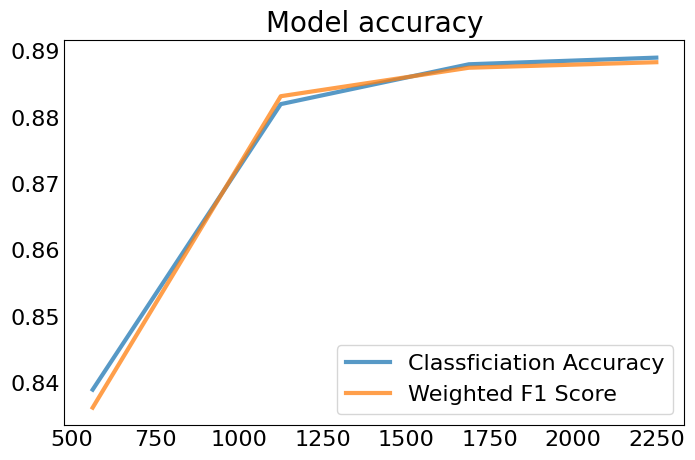

In [113]:
result_validation_score = results[results['classification/accuracy'].notnull()]

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(result_validation_score['classification/accuracy'], linewidth=3, label='Classficiation Accuracy', alpha=.75)
ax.plot(result_validation_score['classification/weighted_f1_score'], linewidth=3, label='Weighted F1 Score', alpha=.75)

ax.tick_params(axis="both", which="both", length=0, labelsize=16)
ax.legend( prop={'size': 16})
plt.title("Fine Tuned Model Accuracy", size=20)


Let's see how the model does with my unseen dataset. For some reason, the CLI tool didn't tell me what my model was called so I'll need to make a few rest calls to figure it out

In [196]:
url = "https://api.openai.com/v1/fine-tunes"
headers = {"Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}"}
fine_tuned_models = [i for i in requests.get(url, headers=headers).json()['data'] if i['status'] == 'succeeded']
fine_tuned_models[0]

{'object': 'fine-tune',
 'id': 'ft-ePW6uZVHcjwYg6Z6LLshxWni',
 'hyperparams': {'n_epochs': 4,
  'batch_size': 16,
  'prompt_loss_weight': 0.01,
  'classification_n_classes': 4,
  'learning_rate_multiplier': 0.1,
  'compute_classification_metrics': True},
 'organization_id': 'org-kubCEApMVHQWlIZ9rMLHiRB9',
 'model': 'ada',
 'training_files': [{'object': 'file',
   'id': 'file-vtQGGISgGM2i1CCT0CC6AIEQ',
   'purpose': 'fine-tune',
   'filename': 'data/x_train-finetune_prepared_train.jsonl',
   'bytes': 11538904,
   'created_at': 1683149693,
   'status': 'processed',
   'status_details': None}],
 'validation_files': [{'object': 'file',
   'id': 'file-WRS4lwRhb90bSkjG75EDFl6P',
   'purpose': 'fine-tune',
   'filename': 'data/x_train-finetune_prepared_valid.jsonl',
   'bytes': 1263233,
   'created_at': 1683149695,
   'status': 'processed',
   'status_details': None}],
 'result_files': [{'object': 'file',
   'id': 'file-eD87qf5l6G3ldsIEQaaHnEIe',
   'purpose': 'fine-tune-results',
   'filenam

In [178]:
# Make sure the model works
ft_model = fine_tuned_models[0]['fine_tuned_model']
res = openai.Completion.create(model=ft_model, prompt=X_test['Consumer_complaint_summary'][0] + '\n\n###\n\n', max_tokens=2, temperature=0, logprobs=5)
res['choices'][0]

<OpenAIObject at 0x1609abdd0> JSON: {
  "finish_reason": "length",
  "index": 0,
  "logprobs": {
    "text_offset": [
      2377,
      2384
    ],
    "token_logprobs": [
      -0.0036992515,
      -4.966285e-05
    ],
    "tokens": [
      " Credit",
      " card"
    ],
    "top_logprobs": [
      {
        " Bank": -5.8106503,
        " Consumer": -7.8401055,
        " Credit": -0.0036992515,
        " credit": -9.531439,
        "Credit": -8.579889
      },
      {
        " CARD": -12.151109,
        " Card": -13.031715,
        " card": -4.966285e-05,
        " cards": -10.998998,
        "card": -11.721839
      }
    ]
  },
  "text": " Credit card"
}

In [173]:
candidate_labels

['Bank account or service', 'Credit card', 'Consumer Loan', 'Student loan']

I somehow have two answers that both say credit, which is a bit odd because only one of the candidate labels have the word 'Credit' in it. It looks like the model learned the labels well but didn't learn that it was entirely impossible for a label to be something other than one of the candidate labels. Interesting. Reading more deeply into the openAI docs, it looks like a better play would have been to map each of these responses to a number and have that in the validation data. Oh well, hard lessons, it still shouldn't be too hard to map the most likely response back to the expected completion so I'll just get my predictions.

In [176]:
candidate_labels

['Bank account or service', 'Credit card', 'Consumer Loan', 'Student loan']

In [195]:
@timeit
def get_prediction(x):
    res = openai.Completion.create(model=ft_model, prompt=x + '\n\n###\n\n', max_tokens=1, temperature=0)
    return res['choices'][0]['text']

X_eval = X_test.copy()

# Average time per prediciton is about ~.16 seconds like making 2000 predictions will take roughly five minutes
X_eval.head(5).Consumer_complaint_summary.apply(get_prediction)

get_prediction = get_prediction.__wrapped__
X_eval['prediction'] = X_eval.Consumer_complaint_summary.apply(get_prediction)

Function get_prediction Took 0.1598 seconds
Function get_prediction Took 0.1483 seconds
Function get_prediction Took 0.1477 seconds
Function get_prediction Took 0.1804 seconds
Function get_prediction Took 0.1429 seconds


In [230]:
X_eval['prediction'].unique().tolist()

['Credit card', 'Consumer Loan', 'Bank account or service', 'Student loan']

In [237]:
label_mapping = X_eval.groupby('Transaction_Type')['prediction'].agg(pd.Series.mode).to_dict()
label_mapping = {v: k for k, v in label_mapping.items()}
predictions = X_eval['prediction'].copy()
X_eval['prediction'] = predictions.map(label_mapping)

,Transaction_Type,Consumer_complaint_summary,prediction
0,Credit card,I have had this Bank of America credit card si...,Credit card
1,Consumer Loan,mi pago fue devuelto por la razón dada ... pag...,Consumer Loan
2,Bank account or service,I was trying to use my debit card XXXX / XXXX ...,Bank account or service
3,Bank account or service,"Mes deux parents sont décédés, me laissant com...",Bank account or service
4,Consumer Loan,The ACE CASH services have threatened to take ...,Consumer Loan


In [239]:
accuracy = (X_eval[target]==X_eval['prediction']).sum() / len(X_eval)
print("Accuracy {:.2%}".format(accuracy))

Accuracy 89.78%


So this method works pretty well! In a purely text space, the fine tuned model performed better on our unseen data than our ngrams $\rightarrow$ stochastic gradient descent pipeline. 

### Perks and drawbacks of this approach

Stengths:
- The model is our most accurate so far
- It uses [online Learning](https://en.wikipedia.org/wiki/Online_machine_learning) rather than training from scratch which I see as a huge benefit
- You get to use LLMs

Weaknesses:
- You need to actually make a training dataset
- It costs you money both at training time and prediction time
- You can only use one feature which must be freeform text or an image


### Approach 4: Zeroshot Inference and Machine Learning

This idea is basically why I decided to write this whole article. We saw earlier that approach two didn't work for our use case and that inference takes a prohibitively long time anyway which disqualifies it from being put in front of an end user. But if we could take only the highest quality guesses from the LLM, it might be possible to use those as training data for a downstream process. How do we decide if a prediction has high quality? One idea might simply be to take the N most confident predictions as training data. Then we, train our machine learning model as normal and infer the rest of the labels.

In [89]:
with open('data/zero_shot_predictions.json', 'r') as f:
    preds = json.load(f)

predictions = (pd.DataFrame([
    {
        i['labels'][0]: i['scores'][0],
        i['labels'][1]: i['scores'][1],
        i['labels'][2]: i['scores'][2],
        i['labels'][3]: i['scores'][3],
    }
    for i in preds['data']
])
    .head(10000)
    .assign(max_similarity = lambda x: x.max(axis=1))
    .assign(training_label = lambda x: x.idxmax(axis=1))
    .sort_values(by='max_similarity', ascending=False)
)
predictions.head(5)


,Bank account or service,Consumer Loan,Credit card,Student loan,max_similarity,training_label
534,0.002259,0.003103,0.993874,0.000765,0.993874,Credit card
8586,0.003623,0.002402,0.001331,0.992643,0.992643,Student loan
1640,0.002953,0.004880,0.000889,0.991278,0.991278,Student loan
9064,0.003029,0.004912,0.002794,0.989266,0.989266,Student loan
619,0.003428,0.005665,0.001917,0.988990,0.988990,Student loan


I set a similarity cutoff point to 0.75 to make our training dataset. Doing this gives us a set of ~2500 training records, ~85% of which match the training label.  Hopefully good enough to begin modeling! 

(6475, 8)
70.01%


<Axes: title={'center': 'Distribution of our Inferred Training Labels'}>

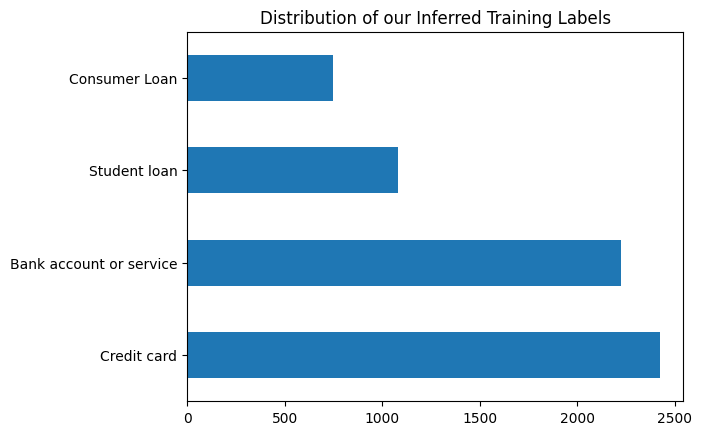

In [114]:
pred_merge = predictions.merge(X_train, left_index=True, right_index=True).loc[lambda x: x.max_similarity > .5]

print(pred_merge.shape)

# Show % of correct records
print(format(sum(pred_merge.training_label == pred_merge.Transaction_Type) / len(pred_merge), '.2%'))

(pred_merge[target]
 .value_counts()
 .plot(kind='barh', title='Distribution of our Inferred Training Labels')
)

Now we can kick off the exact same process we did in approach 1, where we let DataRobot take care of the modeling. Again, we could follow this same approach using scikit-learn or another package but this will be a lot easier.

In [115]:
X_zero_shot_train = (
    pred_merge[['training_label', 'Consumer_complaint_summary']]
    .rename(columns={'training_label': 'Transaction_Type'})
)

zero_shot_label_project = drx.AutoMLModel(name="Zero Shot Email Classifier").fit(X_zero_shot_train, target=target)

VBox()

In [116]:
# Make some predictions
pred_probas = zero_shot_label_project.predict_proba(X_test)
preds = zero_shot_label_project.predict(X_test)

VBox()

VBox()

In [117]:
X_eval = pd.concat((X_test.reset_index(drop=True), preds, pred_probas),axis=1)
X_eval.head()

,Transaction_Type,Consumer_complaint_summary,prediction,class_Bank account or service,class_Consumer Loan,class_Credit card,class_Student loan
0,Credit card,I have had this Bank of America credit card si...,Credit card,0.424384,0.001479,0.571608,0.002528
1,Consumer Loan,mi pago fue devuelto por la razón dada ... pag...,Bank account or service,0.948888,0.002129,0.037903,0.011080
2,Bank account or service,I was trying to use my debit card XXXX / XXXX ...,Bank account or service,0.992522,0.000334,0.006160,0.000984
3,Bank account or service,"Mes deux parents sont décédés, me laissant com...",Bank account or service,0.922433,0.002214,0.066311,0.009041
4,Consumer Loan,The ACE CASH services have threatened to take ...,Bank account or service,0.768362,0.055789,0.026825,0.149025


In [118]:
accuracy = (X_eval[target]==X_eval['prediction']).sum() / len(X_test)
prediction_probabilities = pred_probas.values
logloss = log_loss(X_eval[target], prediction_probabilities, labels=[i.replace('class_', "") for i in pred_probas.columns.to_list()])

print("Accuracy {:.2%}".format(accuracy))
print("LogLoss {:.2}".format(logloss))

Accuracy 50.35%
LogLoss 1.7


Our accuracy here is actually worse than zero shot labeling on the entire test set. I wish I could say that choosing a more strict cutoff point would improve the performance of the model but I tried and it didn't. 

Overall, this approach was pretty disappointing, which adds credence to the idea that ground truth training data is important. Not that anybody should have disagreed with that in the first place.

### Perks and drawbacks of this approach

Stengths:
- You don't need to hand label anything
- You get to use LLMs
- Combining zero-shot inference with machine learning seems like a cool idea
- You can still use other features at model training time

Weaknesses:
- Inference takes a very long time
- The model was the least accurate so far
- Writing poor candidate labels can destroy your predictions
- Like with our second approach, we're still stuck with exclusively classification problems. Continuous outcomes cannot be predicted with this method


## Concluding thoughts

In this post, I tried four different approaches for handling a multiclass classification problem. I found that both traditional machine learning and fine tuning could address this problem with a high degree of accuracy. The biggest takeaway (and maybe disappointment) was that zero-shot inference was neither a substitute for labeled training data nor a good way to generate training data for a downstream process. So it goes. In future work, it would be interesting to see if using a different LLM would improve the performance of my second or fourth approaches.